In [1]:
import os
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchaudio
from IPython.display import Audio, display

For information about the different datasets, go to: https://pytorch.org/audio/stable/datasets.html 

## Helpers Functions

In [2]:
def get_dataset(dataset_name : str, url: str | None = None, subset : str | None = None):
    """
    Retrieves a dataset and downloads it locally if needed.
        
    Inputs
    ------
    dataset_name : str
        Name of the dataset to download. Allowed dataset names: "librispeech", "librilightlimited", "tedlium"
    
    url : (str, optional)
        Optional argument for some datasets 
    
    subset : (str, optional)
        Optional argument for some datasets 
    
    Returns
    -------
    dataset :
        A torchaudio.dataset
    
    """
    _SAMPLE_DIR = "_assets"
    dataset_name = dataset_name.lower()
    dataset_path = os.path.join(_SAMPLE_DIR, dataset_name)
    os.makedirs(dataset_path, exist_ok=True)
        
    if dataset_name == "librispeech":
        url = url if url else "dev-clean"
        print(f"You're about to download librispeech with url {url}")
        dataset = torchaudio.datasets.LIBRISPEECH(dataset_path, download=True, url=url)
    
    elif dataset_name == "librilightlimited":
        subset = subset if subset else "10min"
        print(f"You're about to download librispeech with subset {subset}")
        dataset = torchaudio.datasets.LibriLightLimited(dataset_path, download=True, subset=subset)
        
    elif dataset_name == "tedlium":
        subset = subset if subset else "train"
        print(f"You're about to download Tedlium with subset {subset}")
        dataset = torchaudio.datasets.TEDLIUM(dataset_path, download=True, subset=subset)
    
    else:
        raise ValueError(f"The dataset you passed '{dataset_name}' is not in the list of datasets")
    
    print("\n Done downloading")
    return dataset 

def play_audio(waveform : torch.Tensor, sample_rate : int) -> None:
    """
    Plays audio given a waveform and sample rate
    
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")
        
def plot_specgram(waveform : torch.Tensor, sample_rate : int , title : str ="Spectrogram", xlim=None) -> None:
    """
    Plots a spectogram of audio given a waveform and sample rate
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_waveform(waveform : torch.Tensor, sample_rate : int, title : str ="Waveform", xlim : float | None =None, ylim : float | None=None) -> None:
    """
    Plots the waveform of an audio sample
    """
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)
    
def visualize_random_sample(dataset, play_waveform : bool = True, plot_wave : bool = False, plot_spectogram : bool = False) -> None:
    """
    Takes a random sample in the dataset and displays relevant metrics
    """
    dataset_length = dataset.__len__()
    # get a random sample in the dataset
    sample_id = randint(0, dataset_length)
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(sample_id)
    print('waveform: ', waveform)
    print('sample_rate: ', sample_rate)
    print('transcript: ', transcript)
    print('speaker_id: ', speaker_id)
    
    if play_waveform:
        play_audio(waveform, sample_rate)
        
    if plot_wave:
        plot_waveform(waveform, sample_rate)
    
    if plot_spectogram:
        plot_specgram(waveform, sample_rate, title=f"Sample {sample_id}, Speaker_id {speaker_id}")
        
def calculate_statistics(dataset, verbose : bool = True) -> pd.DataFrame:
    """
    Calculates and plots statistics about the dataset
    
    Inputs
    ------
    dataset :
        The dataset to calculate statistics for
        
    verbose : bool
        If true, it will print the statistics
        
    Returns
    -------
    df_info : pd.DataFrame
        A dataframe with statistics about the dataset. Can be used to make your own statistics
    """
    print(f"Dataset has {dataset.__len__()} samples")
    print(f"Random samples has shape: {dataset.__getitem__(0)[0].shape}")
    
    waveform_lengths = []
    sample_rates = []
    transcript_lengths = []
    speaker_ids = []
    audio_durations = []    
    
    for i in range(dataset.__len__()):
        (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
        waveform_lengths.append(waveform[0].shape[0])
        sample_rates.append(sample_rate)
        transcript_lengths.append(len(transcript))
        speaker_ids.append(speaker_id)
        
        num_channels, num_frames = waveform.shape
        duration = num_frames / sample_rate
        audio_durations.append(duration)
        
    dataset_stats = pd.DataFrame.from_dict(
    {
        "waveform_lengths" : waveform_lengths,
        "sample_rates" : sample_rates,
        "transcript_lengths" : transcript_lengths,
        "audio_durations" : audio_durations,
    }
    )
    
    print(f"Unique speaker ids: {len(np.unique(speaker_ids))}")
    display(dataset_stats.describe().loc[["min","std","min","max"]].round())
    print("\n")
    
    # plotting:
    fig, ax = plt.subplots(1, dataset_stats.shape[1], figsize=(16, 8))
    for i, col in enumerate(dataset_stats.columns):
        ax[i].boxplot(dataset_stats[col])
        ax[i].set_title(col)
    plt.tight_layout()
    
    plt.figure()
    plt.scatter(dataset_stats["waveform_lengths"], dataset_stats["transcript_lengths"])
    plt.xlabel("waveform_lengths")
    plt.ylabel("transcript_lengths")
    
    return dataset_stats

## LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

In [3]:
dataset_name = "librispeech"
dataset = get_dataset(dataset_name)

You're about to download librispeech with url dev-clean

 Done downloading


waveform:  tensor([[ 0.0000e+00,  3.0518e-05,  3.0518e-05,  ...,  3.0518e-05,
         -3.0518e-05, -3.0518e-05]])
sample_rate:  16000
transcript:  THERE WAS THE OLD IMPERIOUS NOTE IN HIS FAILING WHISPER
speaker_id:  251


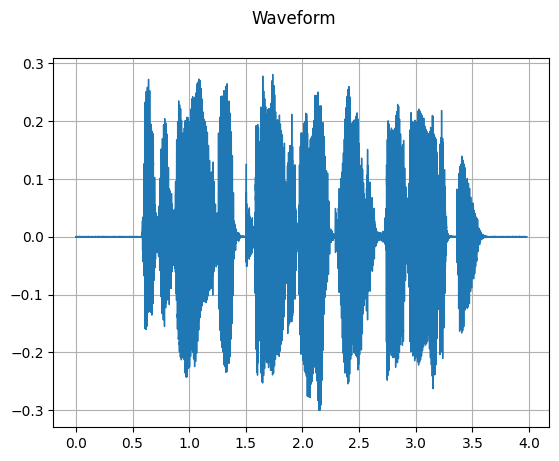

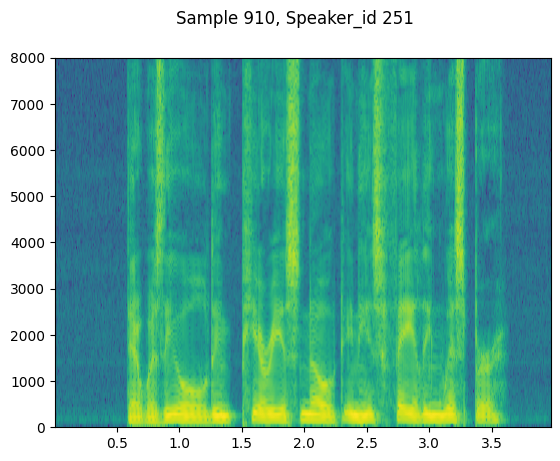

In [4]:
visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

Dataset has 2703 samples
Random samples has shape: torch.Size([1, 93680])
Unique speaker ids: 40


,waveform_lengths,sample_rates,transcript_lengths,audio_durations
min,23120.0,16000.0,3.0,1.0
std,75130.0,0.0,74.0,5.0
min,23120.0,16000.0,3.0,1.0
max,522320.0,16000.0,516.0,33.0


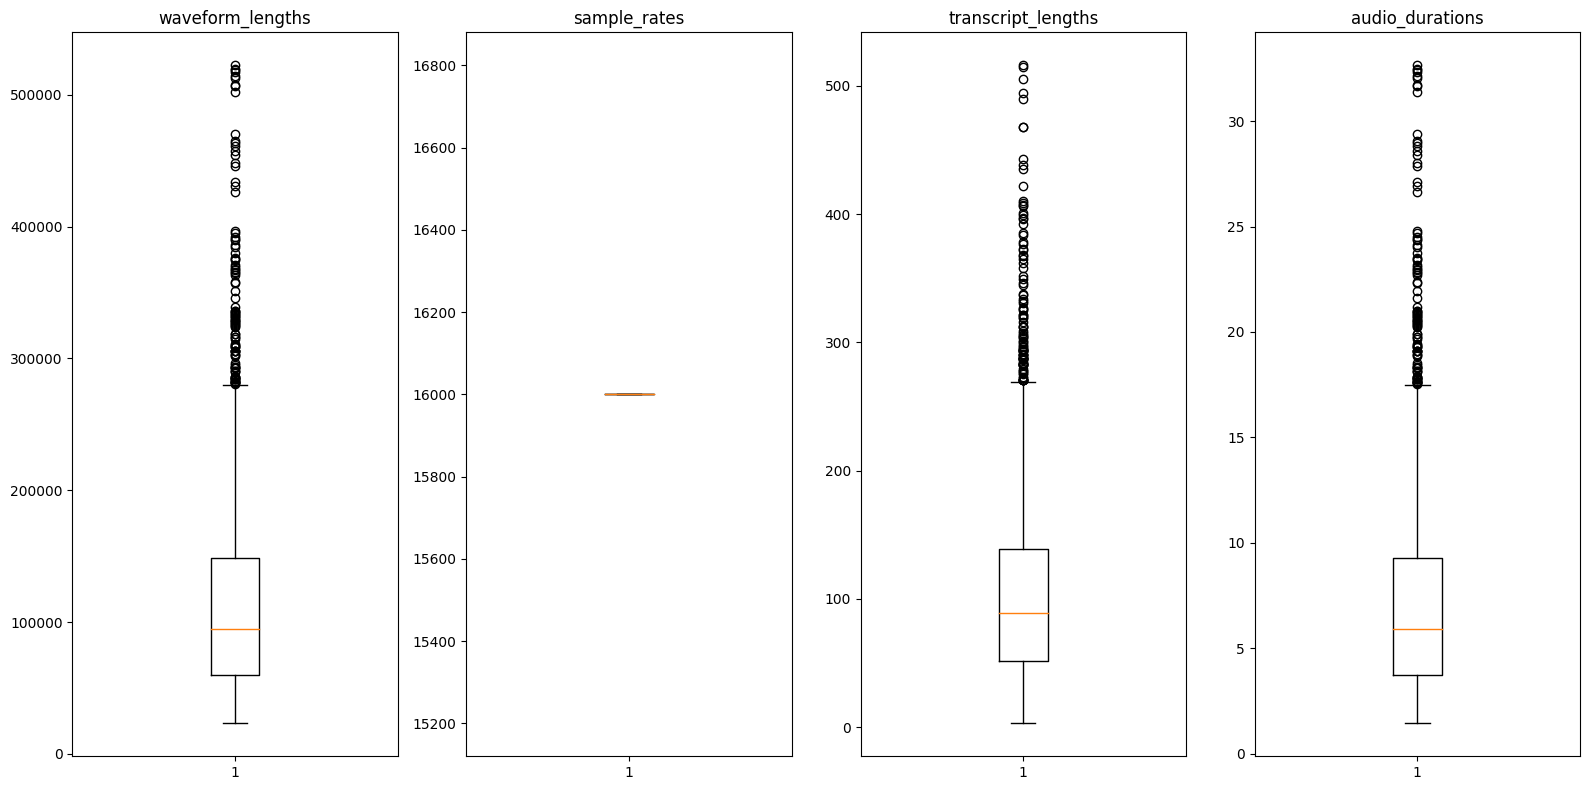

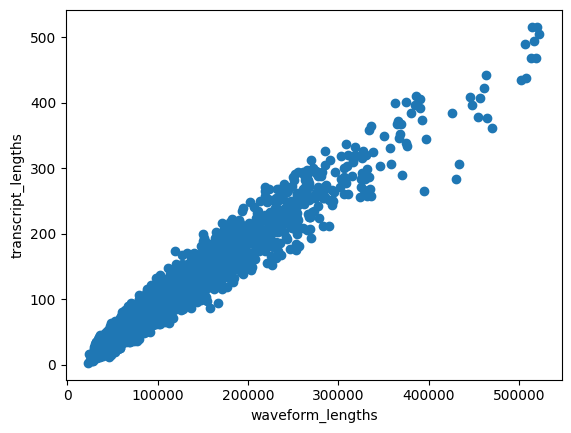

In [5]:
df = calculate_statistics(dataset)

## LibriLightLimited
Libri-light is a benchmark for the training of automatic speech recognition (ASR) systems with limited or no supervision. It contains a large dataset of 60K hours of unlabelled speech from audiobooks in English and a small labelled dataset (10h, 1h, and 10 min) plus metrics, trainable baseline models, and pretrained models that use these datasets.



In [6]:
dataset_name = "LibriLightLimited"
dataset = get_dataset(dataset_name)

You're about to download librispeech with subset 10min

 Done downloading


In [7]:
visualize_random_sample(dataset)

waveform:  tensor([[ 0.0085,  0.0087,  0.0087,  ..., -0.0037, -0.0038, -0.0038]])
sample_rate:  16000
transcript:  HE HAD ALSO BEEN FORTUNATE ENOUGH TO SECURE SOME OF THE POLICE CONTRACTS AND IN THE END HE HAD BECOME RICH ENOUGH TO BE ALLUDED TO IN THE DUBLIN NEWSPAPERS AS A MERCHANT PRINCE HE HAD SENT HIS SON TO ENGLAND TO BE EDUCATED IN A BIG CATHOLIC COLLEGE
speaker_id:  3607


Dataset has 48 samples
Random samples has shape: torch.Size([1, 175920])
Unique speaker ids: 4


,waveform_lengths,sample_rates,transcript_lengths,audio_durations
min,43840.0,16000.0,39.0,3.0
std,53631.0,0.0,60.0,3.0
min,43840.0,16000.0,39.0,3.0
max,269760.0,16000.0,291.0,17.0


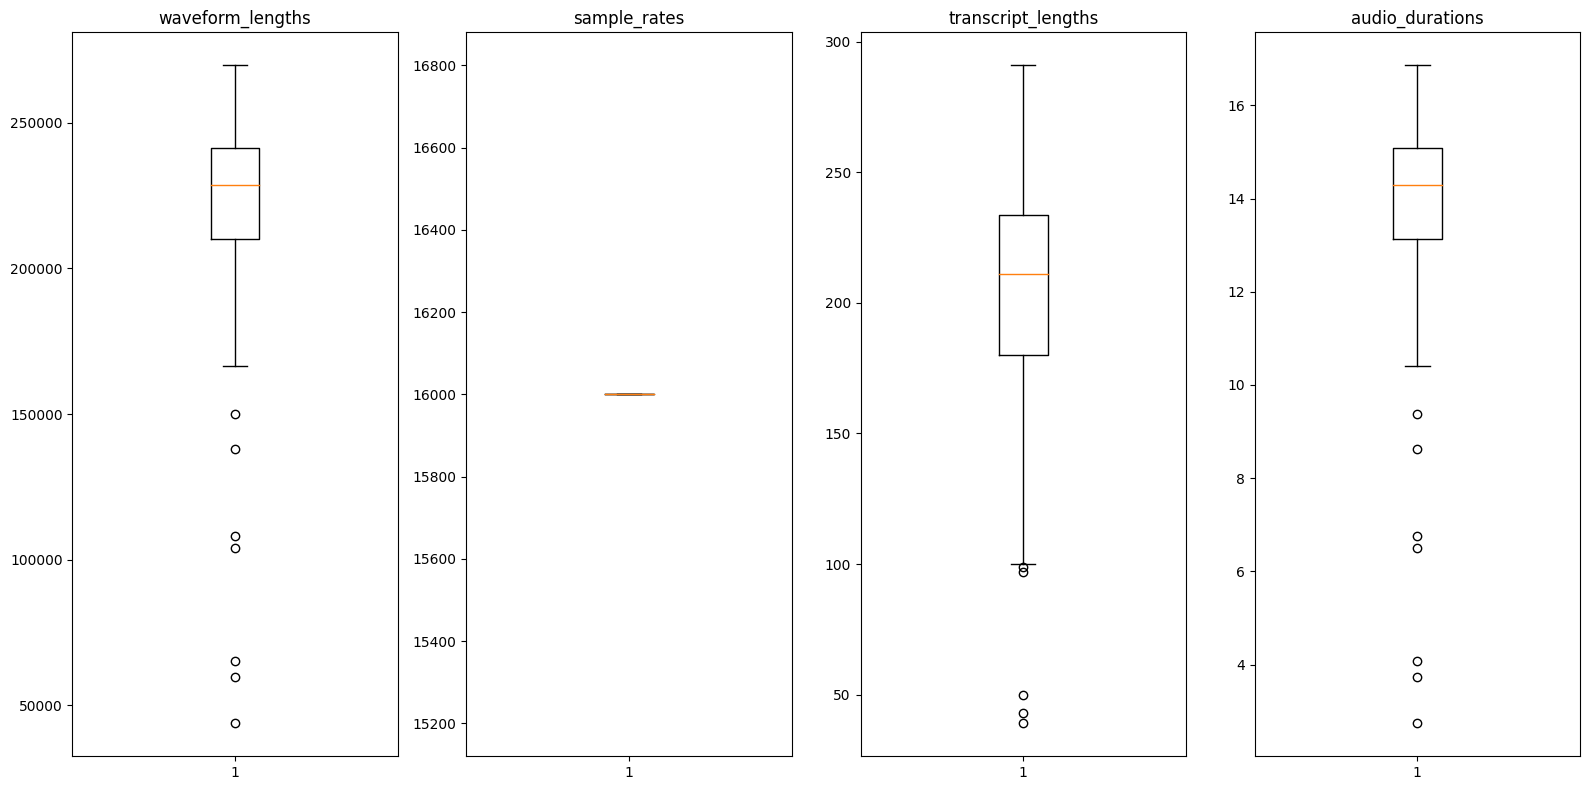

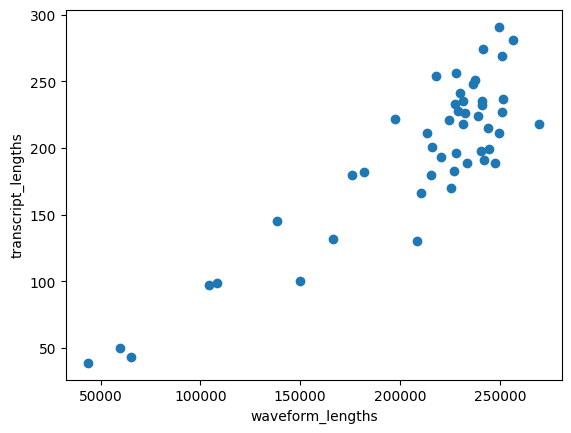

In [8]:
df = calculate_statistics(dataset)

## Tedlium
The TED-LIUM corpus is English-language TED talks, with transcriptions, sampled at 16kHz. It contains about 118 hours of speech.

In [9]:
dataset_name = "Tedlium"
dataset = get_dataset(dataset_name)

You're about to download Tedlium with subset train

 Done downloading


In [10]:
visualize_random_sample(dataset)

waveform:  tensor([[-0.1339, -0.1581, -0.1613,  ...,  0.0118,  0.0128,  0.0121]])
sample_rate:  16000
transcript:  we have(2) all {COUGH} this but what are(2) we going to {SMACK} do with {COUGH} it <sil> it's called <sil> all the answers <sil> (RaulMidonANSWERS_2007-84.00-88.70-F0_M-S10)

speaker_id:  RaulMidonANSWERS_2007


Dataset has 56803 samples
Random samples has shape: torch.Size([1, 183680])
Unique speaker ids: 774


,waveform_lengths,sample_rates,transcript_lengths,audio_durations
min,1920.0,16000.0,41.0,0.0
std,57324.0,0.0,87.0,4.0
min,1920.0,16000.0,41.0,0.0
max,324160.0,16000.0,627.0,20.0


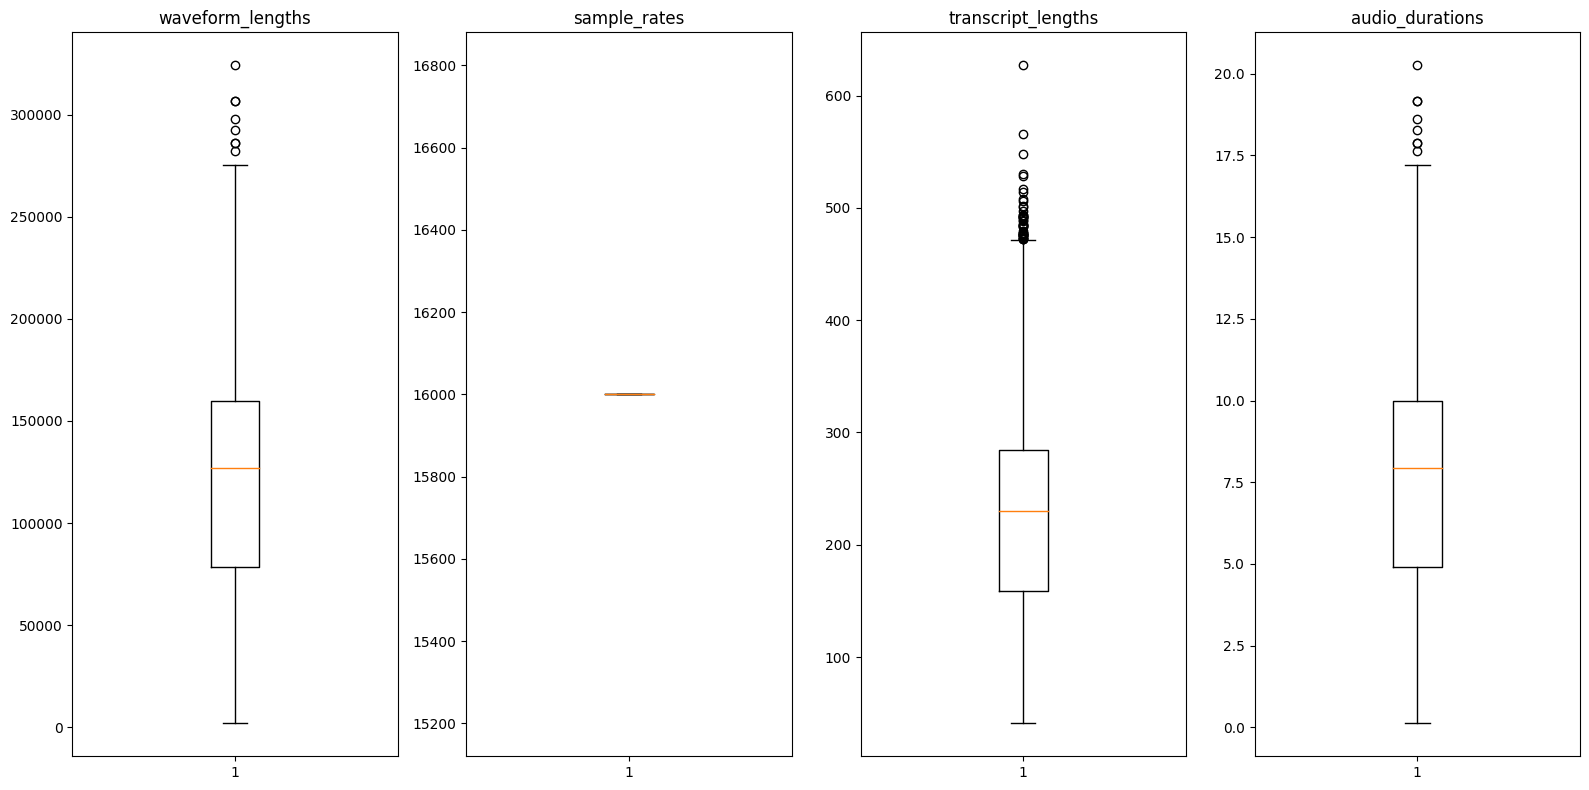

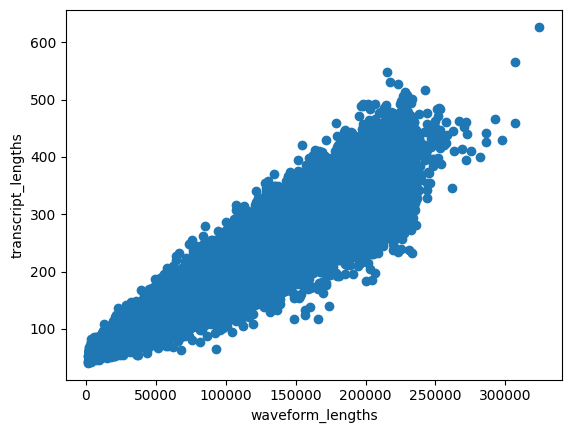

In [11]:
df = calculate_statistics(dataset)